# Import libraries

In [1]:
import pandas as pd
import tensorflow as tf
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
SEED = 42

2025-08-09 16:53:48.796763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-09 16:53:48.800505: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-09 16:53:48.809503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754751228.823879   27461 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754751228.827772   27461 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754751228.840477   27461 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Load data

In [2]:
data_path = Path('datasets/cleaned_data.csv')
data = pd.read_csv(data_path)
data = data.drop('ID', axis=1)
labels = data.pop('Label')

data.head

<bound method NDFrame.head of      Duration  Distance  Energy  Avg. speed  Max. speed    Steps  Ascent  \
0        7132      9.26     522         4.0        39.0  11955.0  607.20   
1         899      2.95     275        11.0        14.0   2390.0  100.40   
2        5146      6.42     366         4.0        49.0   8586.0  269.20   
3        5421      6.33     364         4.0         6.0   8982.0  130.30   
4        5231      5.72     344         3.0         9.0   8006.0  190.40   
..        ...       ...     ...         ...         ...      ...     ...   
478       899      2.77     190        11.0        15.0   2293.0   45.00   
479       930      2.87     203        11.0        14.0   2380.0   47.75   
480       667      2.09     146        11.0        15.0   1698.0   29.10   
481       987      2.96     212        10.0        55.0   2442.0   61.05   
482       752      2.08     142         9.0        14.0   1785.0  121.45   

     Descent  
0     605.00  
1     102.10  
2     284.10

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Duration    483 non-null    int64  
 1   Distance    483 non-null    float64
 2   Energy      483 non-null    int64  
 3   Avg. speed  483 non-null    float64
 4   Max. speed  483 non-null    float64
 5   Steps       483 non-null    float64
 6   Ascent      483 non-null    float64
 7   Descent     483 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 30.3 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration,483.0,2539.637681,1928.602612,157.0,1059.500,1851.00,3569.000,11197.00
Distance,483.0,5.119337,4.567859,0.0,2.655,4.04,6.080,31.95
Energy,483.0,278.459627,184.248479,29.0,173.500,244.00,328.000,1519.00
Avg. speed,483.0,7.347826,4.467393,0.0,4.000,5.00,11.000,17.00
Max. speed,483.0,17.672878,22.137552,0.0,7.000,13.00,21.000,240.00
Steps,483.0,3892.451346,3371.579251,0.0,1779.000,3418.00,5500.500,16176.00
Ascent,483.0,151.931532,144.433714,0.0,58.985,104.65,213.935,905.90
Descent,483.0,158.126812,139.905396,0.0,74.085,117.05,211.835,915.40


In [5]:
labels.value_counts().values

array([203, 171,  54,  43,   5,   5,   2])

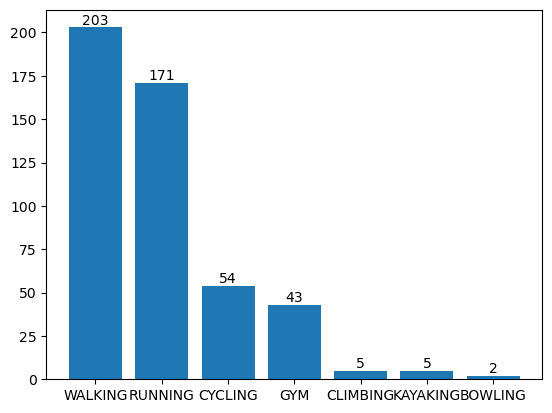

In [6]:
fig, ax = plt.subplots()

barplot = ax.bar(labels.value_counts().keys(), labels.value_counts().values)

for bar in barplot:
    text = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2,
            text, text, ha='center', va='bottom')


plt.show()

# Feature engineering

In [7]:
def energy_per_km(row):
    if row['Distance'] > 0:
        return row['Energy'] / row['Distance']
    else:
        return 0
    
data['Energy Per Km'] = data.apply(energy_per_km, axis=1)

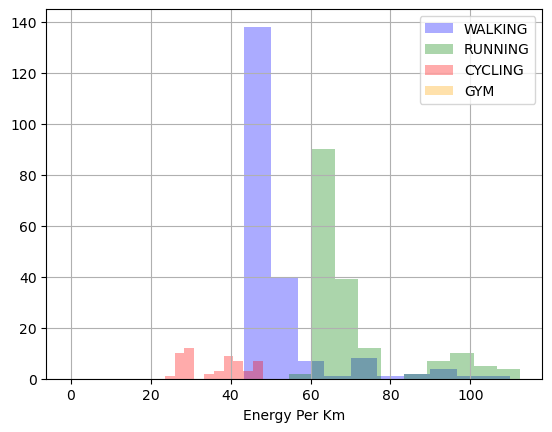

In [8]:
def show_hist_based_on_labels(feature):
    classes = labels.unique()

    colors = ['blue', 'green', 'red', 'orange'] # 4 most popular labels

    for class_, color in zip(classes, colors):
        subset = data[labels == class_]
        plt.hist(subset[feature], bins=10, alpha=0.33, label=class_, color=color, histtype='bar')

    plt.xlabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

feature = 'Energy Per Km'
show_hist_based_on_labels(feature) 
data = data.drop(feature, axis=1)

# Preprocessing

In [9]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

num_pipeline

Pipeline(steps=[('scaler', StandardScaler())])

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA


class Reducter(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)

    def fit(self, X, Y=None):
        self.pca.fit(X)
        return self

    def transform(self, X):
        return self.pca.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return [f'Reducted#{i+1}' for i in range(self.n_components)]

In [11]:
reducter_pipeline = Pipeline([
    ('num_pipeline', num_pipeline),
    ('reducter', Reducter(n_components=2)),
])

reducter_pipeline

Pipeline(steps=[('num_pipeline',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('reducter', Reducter())])

In [12]:
from sklearn.pipeline import FunctionTransformer
import numpy as np

def energy_per_km(features):
    energy_index = data.columns.to_list().index('Energy')
    distance_index = data.columns.to_list().index('Distance')

    distance = features[:, distance_index]
    energy = features[:, energy_index]
    safe_distance = np.where(distance == 0, np.nan, distance)

    result = energy / safe_distance
    result = np.nan_to_num(result, nan=0.0)
    return result.reshape(-1, 1)

feature_pipeline = Pipeline([
    ('energy_per_km', FunctionTransformer(energy_per_km, feature_names_out=lambda _, __: ['Energy Per Km'])),
    ('scaler', StandardScaler()),
])

feature_pipeline

Pipeline(steps=[('energy_per_km',
                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7a3b80299440>,
                                     func=<function energy_per_km at 0x7a3b7f9bdb20>)),
                ('scaler', StandardScaler())])

In [13]:
from sklearn.pipeline import FeatureUnion


union = FeatureUnion([
    ('num', num_pipeline),
    ('reducter', reducter_pipeline),
    ('feature', feature_pipeline),
])

union

FeatureUnion(transformer_list=[('num',
                                Pipeline(steps=[('scaler', StandardScaler())])),
                               ('reducter',
                                Pipeline(steps=[('num_pipeline',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler())])),
                                                ('reducter', Reducter())])),
                               ('feature',
                                Pipeline(steps=[('energy_per_km',
                                                 FunctionTransformer(feature_names_out=<function <lambda> at 0x7a3b80299440>,
                                                                     func=<function energy_per_km at 0x7a3b7f9bdb20>)),
                                                ('scaler',
                                                 StandardScaler())]))])

In [14]:
preprocess = Pipeline([
    ('imputer', SimpleImputer()),
    ('union', union)
])

preprocess

Pipeline(steps=[('imputer', SimpleImputer()),
                ('union',
                 FeatureUnion(transformer_list=[('num',
                                                 Pipeline(steps=[('scaler',
                                                                  StandardScaler())])),
                                                ('reducter',
                                                 Pipeline(steps=[('num_pipeline',
                                                                  Pipeline(steps=[('scaler',
                                                                                   StandardScaler())])),
                                                                 ('reducter',
                                                                  Reducter())])),
                                                ('feature',
                                                 Pipeline(steps=[('energy_per_km',
                                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x7a3b80299440>,
                                                                                      func=<function energy_per_km at 0x7a3b7f9bdb20>)),
                                                                 ('scaler',
                                                                  StandardScaler())]))]))])

In [15]:
pd.DataFrame(preprocess.fit_transform(data), columns=preprocess.get_feature_names_out())

,num__Duration,num__Distance,num__Energy,num__Avg. speed,num__Max. speed,num__Steps,num__Ascent,num__Descent,reducter__Reducted#1,reducter__Reducted#2,feature__Energy Per Km
0,2.383655,0.907418,1.323174,-0.750168,0.964390,2.393806,3.155361,3.197421,5.170298,2.278383,0.145308
1,-0.851569,-0.475406,-0.018796,0.818365,-0.166084,-0.446084,-0.357153,-0.400877,-0.851213,-0.981999,1.659790
2,1.352826,0.285038,0.475614,-0.750168,1.416580,1.393535,0.812761,0.901350,1.975970,1.445672,0.171524
3,1.495565,0.265314,0.464748,-0.750168,-0.527835,1.511110,-0.149923,-0.153311,0.813381,2.033443,0.191852
4,1.396946,0.131634,0.356086,-0.974245,-0.392178,1.221331,0.266616,0.268840,0.976760,1.935624,0.300188
...,...,...,...,...,...,...,...,...,...,...,...
478,-0.851569,-0.514852,-0.480608,0.818365,-0.120865,-0.474884,-0.741118,-0.835764,-1.426267,-0.944973,0.647572
479,-0.835479,-0.492938,-0.409978,0.818365,-0.166084,-0.449054,-0.722058,-0.825532,-1.370447,-0.923447,0.735511
480,-0.971988,-0.663873,-0.719664,0.818365,-0.120865,-0.651542,-0.851317,-0.942876,-1.767754,-1.051308,0.699538
481,-0.805893,-0.473214,-0.361081,0.594289,1.687893,-0.430645,-0.629879,-0.717705,-0.961384,-1.157361,0.772086


# Feature selection

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier


feature_selection = Pipeline([
    ('preprocessing', preprocess),
    ('selection', RFECV(estimator=DecisionTreeClassifier(random_state=SEED), cv=StratifiedKFold(3, shuffle=True, random_state=SEED), scoring='accuracy'))
])

feature_selection

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('union',
                                  FeatureUnion(transformer_list=[('num',
                                                                  Pipeline(steps=[('scaler',
                                                                                   StandardScaler())])),
                                                                 ('reducter',
                                                                  Pipeline(steps=[('num_pipeline',
                                                                                   Pipeline(steps=[('scaler',
                                                                                                    StandardScaler())])),
                                                                                  ('reducter',
                                                                                   Reducter())])),
                                                                 ('feature',
                                                                  Pipeline(steps=[('energy_per_km',
                                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x7a3b80299440>,
                                                                                                       func=<function energy_per_km at 0x7a3b7f9bdb20>)),
                                                                                  ('scaler',
                                                                                   StandardScaler())]))]))])),
                ('selection',
                 RFECV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                       estimator=DecisionTreeClassifier(random_state=42),
                       scoring='accuracy'))])

In [17]:
from sklearn.calibration import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)
pd.DataFrame(feature_selection.fit_transform(data, labels), columns=feature_selection.get_feature_names_out())

/home/user/miniconda3/envs/sportstracker-scrapper-model/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


,num__Energy,num__Avg. speed,num__Steps,feature__Energy Per Km
0,1.323174,-0.750168,2.393806,0.145308
1,-0.018796,0.818365,-0.446084,1.659790
2,0.475614,-0.750168,1.393535,0.171524
3,0.464748,-0.750168,1.511110,0.191852
4,0.356086,-0.974245,1.221331,0.300188
...,...,...,...,...
478,-0.480608,0.818365,-0.474884,0.647572
479,-0.409978,0.818365,-0.449054,0.735511
480,-0.719664,0.818365,-0.651542,0.699538
481,-0.361081,0.594289,-0.430645,0.772086


# RandomForestClassifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")



forest_pipeline = Pipeline([
    ('feature_selection', feature_selection),
    ('forest', RandomForestClassifier(random_state=SEED))
])


forest_params = [
    {
        'forest__n_estimators': [15, 50, 100],
        'forest__max_depth': [None, 15, 50],
    },
]

forest_searching = GridSearchCV(forest_pipeline, forest_params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), scoring='accuracy', refit=True)
forest_searching.fit(data, labels)

print(forest_searching.best_params_)
pd.DataFrame(forest_searching.cv_results_).sort_values(by='rank_test_score', ascending=True)

{'forest__max_depth': None, 'forest__n_estimators': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest__max_depth,param_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.093117,0.003968,0.007406,0.000798,None,50,"{'forest__max_depth': None, 'forest__n_estimat...",0.989691,1.0,0.989691,0.989583,0.989583,0.991710,0.004145,1
2,0.138229,0.006180,0.008399,0.000331,None,100,"{'forest__max_depth': None, 'forest__n_estimat...",0.989691,1.0,0.989691,0.989583,0.989583,0.991710,0.004145,1
5,0.137401,0.011027,0.010779,0.001713,15,100,"{'forest__max_depth': 15, 'forest__n_estimator...",0.989691,1.0,0.989691,0.989583,0.989583,0.991710,0.004145,1
4,0.094730,0.010178,0.007383,0.001126,15,50,"{'forest__max_depth': 15, 'forest__n_estimator...",0.989691,1.0,0.989691,0.989583,0.989583,0.991710,0.004145,1
7,0.098909,0.003651,0.008242,0.001600,50,50,"{'forest__max_depth': 50, 'forest__n_estimator...",0.989691,1.0,0.989691,0.989583,0.989583,0.991710,0.004145,1
8,0.134151,0.005940,0.009539,0.001375,50,100,"{'forest__max_depth': 50, 'forest__n_estimator...",0.989691,1.0,0.989691,0.989583,0.989583,0.991710,0.004145,1
3,0.068674,0.004412,0.005926,0.000970,15,15,"{'forest__max_depth': 15, 'forest__n_estimator...",0.989691,1.0,0.979381,0.979167,0.989583,0.987564,0.007755,7
0,0.066433,0.005603,0.005974,0.000917,None,15,"{'forest__max_depth': None, 'forest__n_estimat...",0.989691,1.0,0.979381,0.979167,0.989583,0.987564,0.007755,7
6,0.068794,0.004319,0.005694,0.000743,50,15,"{'forest__max_depth': 50, 'forest__n_estimator...",0.989691,1.0,0.979381,0.979167,0.989583,0.987564,0.007755,7


Accuracy: 1.0


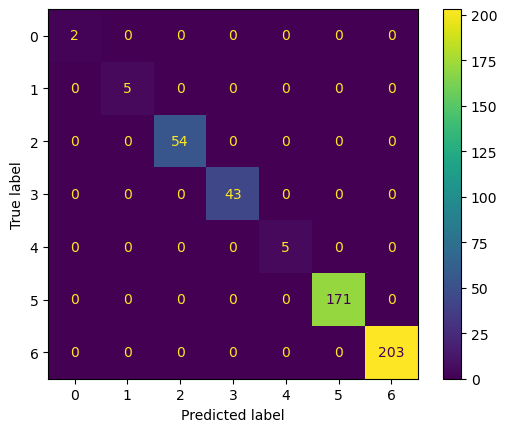

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

model = forest_searching.best_estimator_ 
preds = model.predict(data)
print(f'Accuracy: {accuracy_score(labels, preds)}')
ConfusionMatrixDisplay(confusion_matrix(labels, preds)).plot()

# Neural Network